# **DAVIDE BULOTTA ------ Assignment 2**

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.functional import F
from torchmetrics import Dice
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import numpy as np
import torch
import os

# Read Dataset

The images was read and collet using Pillow libray

For the model learning all images was converted in RGB matrix

In [3]:
def geImage(idx:int):
    # Read the image and mask
    img_name = 'dataset/horse/horse' + str(idx).zfill(3) + '.png'
    mask_name = 'dataset/mask/horse' + str(idx).zfill(3) + '.png'
    # Open the image and convert it to RGB
    # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open
    # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
    img = Image.open(img_name).convert('RGB')
    # Open the mask
    mask = Image.open(mask_name)
    return img, mask

All images was resized into 640 x 640 for the learning

I've used **torchvision.transforms** for the **resize**, **convert to tensor** and **normalize all images**

In [5]:
# Define the image size
size = (640, 640)

# Define the transformations
# I've used the v1 version of transforms
# https://pytorch.org/vision/stable/transforms.html
# https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize
# https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor
# https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize
# https://pytorch.org/vision/stable/generated/torchvision.transforms.Lambda.html#torchvision.transforms.Lambda

preprocessing_image = transforms.Compose([
    # Resize the image
    transforms.Resize(size),
    # Convert the image to a tensor
    transforms.ToTensor(),
    # Normalize the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocessing_mask = transforms.Compose([
    # Resize the mask
    transforms.Resize(size),
    # Convert the mask to a tensor
    transforms.ToTensor(),
    # Convert the mask to a binary mask
    transforms.Lambda(lambda x: (x > 0).float()),
])

I've splitted for the dataset in 75%/25%

In [6]:
# Create the lists to store the images and masks
images_list = []
masks_list = []

# Loop over the images
for idx in tqdm(range(1,328), desc='Preparing images dataset'): # 1-327
    img, mask = geImage(idx)
    if img is not None:
        img = preprocessing_image(img)
        images_list.append(img)
    if mask is not None:
        mask = preprocessing_mask(mask)
        masks_list.append(mask)

Preparing images dataset: 100%|██████████| 327/327 [00:03<00:00, 108.55it/s]


In [5]:
# Stack the images and masks
train_images = torch.stack(images_list[:246])
train_masks = torch.stack(masks_list[:246])
test_images = torch.stack(images_list[246:])
test_masks = torch.stack(masks_list[246:])

In [6]:
# Create the dataset
train_dataset = TensorDataset(train_images, train_masks)
test_dataset = TensorDataset(test_images, test_masks)
# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# The Convolutional Network

After much indecision, I decided to implement a ResNet architecture by applying a Fully Convolutional Network (FCN) to it.

The reasons for this decision were varied:

&emsp; - Personal interest in implementing a commonly used network like ResNet.

&emsp; - A desire to work with a network that relies solely on convolutions, making it suitable for better understanding this type of architecture.

&emsp; - The flexibility to modify the network, allowing changes from ResNet-50 to ResNet-101.

&emsp; - An opportunity to gain a deeper understanding of how an FCN can be applied to a ResNet.

In particular my ispiration was follow the fcn_resnet50-101 implemented by [pytorch](https://pytorch.org/hub/pytorch_vision_fcn_resnet101/)

For the implementation of this model I've studied from the slide adding different resources online

&emsp; - [Fully Convolutional Network (Semantic Segmentation)](https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1)

&emsp; - [Converting FC Layers to Conv Layers](https://mein2work.medium.com/converting-fc-layers-to-conv-layers-8a43880a44ed)

&emsp; - [Weakly-Labelled Semantic Segmentation of Fish Objects in Underwater Videos Using a Deep Residual Network](https://www.researchgate.net/publication/314071170_Weakly-Labelled_Semantic_Segmentation_of_Fish_Objects_in_Underwater_Videos_Using_a_Deep_Residual_Network) (For fun)

## BasicBlock

In [7]:
# Define the basic block class for the ResNet
class BasicBlock(nn.Module):
    # The expansion is used to increase the number of channels
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # The first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        # The batch normalization layer
        self.bn1 = nn.BatchNorm2d(out_channels)
        # The second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # The batch normalization layer
        self.bn2 = nn.BatchNorm2d(out_channels)
        # The third convolutional layer
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        # The batch normalization layer
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        # The ReLU layer
        self.relu = nn.ReLU(inplace=True)
        # The downsample layer is used to match the dimensions between the residual and the output
        self.downsample = downsample
        
    def forward(self, x):
        # Save the residual
        residual = x
        # If the downsample is not None, apply it
        if self.downsample is not None:
            residual = self.downsample(x)
        # Apply the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Apply the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # Apply the third convolutional layer
        out = self.conv3(out)
        out = self.bn3(out)
        # Add the residual to the output
        out += residual
        out = self.relu(out)
        return out

## ResNet

The ResNet model serves as a powerful backbone for feature extraction in the Fully Convolutional Network (FCN) application.

It utilizes **residual** learning through residual blocks, which help in learning complex features by enabling direct gradient flow through skip connections.

**Max Pooling** is applied early in the network, right after the initial convolution layer.

In [8]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        # The number of input channels
        self.in_channels = 64
        # The first convolutional layer of the ResNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # The batch normalization layer of the ResNet
        self.bn = nn.BatchNorm2d(64)
        # The ReLU layer of the ResNet
        self.relu = nn.ReLU(inplace=True)
        # The maxpool layer of the ResNet
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # The layer1 of the ResNet
        self.layer1 = self.make_layer(block, 64, layers[0])
        # The layer2 of the ResNet
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        # The layer3 of the ResNet
        self.layer3 = self.make_layer(block, 256, layers[2], 2)
        # The layer4 of the ResNet
        self.layer4 = self.make_layer(block, 512, layers[3], 2)

    # Define the make_layer function to create the layers of the ResNet
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        # Check if the input channels is not equal to the output channels
        if stride != 1 or self.in_channels != out_channels * block.expansion: # 64 != 64 * 4 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            ) # 1x1 conv layer
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample)) # 1st layer
        # Update the input channels
        self.in_channels = out_channels * block.expansion
        # Create the remaining layers
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Apply the first step in the ResNet
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # Apply the layer1
        layer1_output = self.layer1(x)
        # Apply the layer2 using the output of layer1
        layer2_output = self.layer2(layer1_output)
        # For FNC ResNet50, we need to save the output of layer3 and layer4
        layer3_output = self.layer3(layer2_output)
        layer4_output = self.layer4(layer3_output)
        # Return the output of layer4 and layer3 for the FNC ResNet50
        return layer4_output, layer3_output

## FCN ResNet

The **FCN Head** is crucial for transforming the high-dimensional feature maps extracted by the backbone into a lower-dimensional space.

I've used a standard convolutional layer with a dropout function to reduce the overfitting problem and after another convolution to remap the tensor into the output class.


In [9]:
# FNC ResNet50 model
class FCNHead(nn.Sequential):
    def __init__(self, in_channels, channels, number_of_classes=1):
        # The layers of the FCN head
        layers = [
            nn.Conv2d(in_channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(channels, number_of_classes, kernel_size=1)
        ]
        super(FCNHead, self).__init__(*layers)

## FCN (Fully Convolutional Networks)

The FCN (Fully Convolutional Network) model is designed to handle image segmentation tasks by converting the feature maps from the ResNet backbone into pixel-wise classification outputs.


In [10]:
class FCN(nn.Module):
    def __init__(self, backbone, classifier, aux_classifier=None):
        super(FCN, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.aux_classifier = aux_classifier

    def forward(self, x):
        # Get the input shape of the image x
        input_shape = x.shape[-2:]
        features, aux_features = self.backbone(x)
        # Get the output
        x = self.classifier(features)
        # Resize the output to the input shape
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

        result = {"out": x}

        if self.aux_classifier is not None:
            # Get the auxiliary output
            aux = self.aux_classifier(aux_features)
            # Resize the output to the input shape
            aux = F.interpolate(aux, size=input_shape, mode='bilinear', align_corners=False)
            result["aux"] = aux

        return result

In [11]:
# Create the FNC ResNet101 model
def FCNResNet50(num_classes=1, aux=True):
    backbone = ResNet(BasicBlock, [3, 4, 6, 3]) # ResNet50
    #backbone = ResNet(BasicBlock, [3, 4, 23, 3]) # ResNet101
    # Create the classifier and the auxiliary classifier for the FNC ResNet50 model
    classifier = FCNHead(2048, 512, num_classes)
    aux_classifier = FCNHead(1024, 256, num_classes) if aux else None
    model = FCN(backbone, classifier, aux_classifier)
    return model

In [12]:
# Create the model
model = FCNResNet50()

In [13]:
# Count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Number of parameters

In [14]:
model_parameters = count_parameters(model)
print(f"Model parameters: {model_parameters}")

Model parameters: 35306818


In [15]:
onnx_file_path = "model.onnx"
model = model.to('cuda:0')
model.eval()
input_tensor = torch.randn(1, 3, 224, 224).cuda()
# Export the model in Open Neural Network eXchange (ONNX) format
# https://pytorch.org/docs/stable/onnx.html
torch.onnx.export(
    model,                      # Pytorch model
    input_tensor,               # Input tensor
    onnx_file_path,             # Output file path
    export_params=True,         # Export the trained parameters
    opset_version=11,           # Version of the ONNX opset to use
    do_constant_folding=True,   # Execute constant folding for optimization
    input_names=['input'],      # Names of the input
    output_names=['out', 'aux'],    # Names of the output
    dynamic_axes={'input': {0: 'batch_size'}, 'out': {0: 'batch_size'}, 'aux': {0: 'batch_size'}} # Dynamic axes
)

# Analyses of the results

## Model choice ResNet50 vs ResNet 101

After conducting numerous tests, I have decided to use ResNet50 instead of ResNet101 for my model architecture for this reasons:

&emsp; - ResNet101 has significantly more parameters than ResNet50, which can lead to a loss of spatial information in the image. For tasks such as image segmentation, where preserving spatial details is crucial, this loss can negatively impact performance.

&emsp; - The higher complexity of ResNet101 increases the risk of overfitting, especially in this case were the dataset is not very large. ResNet50, being less complex, provides a better balance between model capacity and generalization.

&emsp; - ResNet101 requires more computational resources and time to train compared to ResNet50. During my tests, I founded that the training time for ResNet101 was considerably longer without a proportionate improvement in performance. This makes ResNet50 a more practical choice where computational efficiency is a concern.

&emsp; - In terms of performance metrics such as dice coefficient and loss, ResNet50 consistently matched or outperformed ResNet101. This indicates that the additional layers and parameters in ResNet101 do not necessarily translate to better performance for my specific use case.


In [16]:
print(model)

FCN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
dice_coefficient = Dice().cuda()
numb_epochs = 150

# Best model parameters
bestDice = 0.0
bestModel = None
bestEpoch = 0

loss_train = []
dice_train = []
loss_test = []
dice_test = []
for epoch in tqdm(range(1, numb_epochs+1)):
    model.train()
    loss_epoch = 0.0
    dice_epoch = 0.0
    for images, masks in train_loader:
        images = images.cuda()
        masks = masks.cuda()
        #
        output = model(images)
        main_output = model(images)['out']
        aux_output = model(images)['aux']
        #
        loss_main = criterion(main_output, masks)
        loss_aux = criterion(aux_output, masks)
        loss = loss_main + 0.4 * loss_aux
        #
        binary_output = torch.sigmoid(main_output) > 0.5
        masks = masks.int() # Convert the masks to int
        #
        dice = dice_coefficient(binary_output, masks)
        #
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #
        loss_epoch += loss.item()
        dice_epoch += dice.item()
        #
    loss_epoch /= len(train_loader)
    dice_epoch /= len(train_loader)
    loss_train.append(loss_epoch)
    dice_train.append(dice_epoch)

    model.eval()
    loss_epoch = 0.0
    dice_epoch = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.cuda()
            masks = masks.cuda()
            #
            output = model(images)
            main_output = model(images)['out']
            aux_output = model(images)['aux']
            #
            loss_main = criterion(main_output, masks)
            loss_aux = criterion(aux_output, masks)
            loss = loss_main + 0.4 * loss_aux
            #
            binary_output = torch.sigmoid(main_output) > 0.5
            masks = masks.int() # Convert the masks to int
            #
            dice = dice_coefficient(binary_output, masks)
            #
            loss_epoch += loss.item()
            dice_epoch += dice.item()
            #
        loss_epoch /= len(test_loader)
        dice_epoch /= len(test_loader)
        # Check if the model is the best
        if dice_epoch > bestDice:
            bestDice = dice_epoch
            bestModel = model
            bestEpoch = epoch
        #
        loss_test.append(loss_epoch)
        dice_test.append(dice_epoch)
        
    print(f"Epoch: {epoch}, Loss Train: {loss_train[-1]:.4f}, Dice Train: {dice_train[-1]:.4f}, Loss Test: {loss_test[-1]:.4f}, Dice Test: {dice_test[-1]:.4f}")

  1%|          | 1/150 [00:11<29:25, 11.85s/it]

Epoch: 1, Loss Train: 0.7985, Dice Train: 0.7331, Loss Test: 4.9508, Dice Test: 0.7321


  1%|▏         | 2/150 [00:23<28:57, 11.74s/it]

Epoch: 2, Loss Train: 0.6162, Dice Train: 0.7844, Loss Test: 0.7026, Dice Test: 0.7722


  2%|▏         | 3/150 [00:35<28:41, 11.71s/it]

Epoch: 3, Loss Train: 0.6038, Dice Train: 0.7989, Loss Test: 0.6271, Dice Test: 0.7651


  3%|▎         | 4/150 [00:46<28:27, 11.70s/it]

Epoch: 4, Loss Train: 0.5520, Dice Train: 0.8201, Loss Test: 0.5969, Dice Test: 0.7986


  3%|▎         | 5/150 [00:58<28:15, 11.69s/it]

Epoch: 5, Loss Train: 0.5198, Dice Train: 0.8376, Loss Test: 0.6087, Dice Test: 0.7897


  4%|▍         | 6/150 [01:10<28:06, 11.71s/it]

Epoch: 6, Loss Train: 0.5023, Dice Train: 0.8403, Loss Test: 0.5714, Dice Test: 0.7828


  5%|▍         | 7/150 [01:22<27:57, 11.73s/it]

Epoch: 7, Loss Train: 0.4791, Dice Train: 0.8509, Loss Test: 0.5668, Dice Test: 0.8171


  5%|▌         | 8/150 [01:33<27:42, 11.70s/it]

Epoch: 8, Loss Train: 0.4544, Dice Train: 0.8620, Loss Test: 0.5399, Dice Test: 0.8339


  6%|▌         | 9/150 [01:45<27:30, 11.71s/it]

Epoch: 9, Loss Train: 0.4363, Dice Train: 0.8699, Loss Test: 0.4679, Dice Test: 0.8603


  7%|▋         | 10/150 [01:57<27:14, 11.68s/it]

Epoch: 10, Loss Train: 0.4163, Dice Train: 0.8766, Loss Test: 0.4744, Dice Test: 0.8677


  7%|▋         | 11/150 [02:08<26:59, 11.65s/it]

Epoch: 11, Loss Train: 0.3871, Dice Train: 0.8870, Loss Test: 1.1897, Dice Test: 0.8447


  8%|▊         | 12/150 [02:20<26:44, 11.63s/it]

Epoch: 12, Loss Train: 0.3699, Dice Train: 0.8963, Loss Test: 0.4032, Dice Test: 0.8834


  9%|▊         | 13/150 [02:31<26:36, 11.66s/it]

Epoch: 13, Loss Train: 0.3384, Dice Train: 0.9058, Loss Test: 0.3790, Dice Test: 0.8956


  9%|▉         | 14/150 [02:43<26:24, 11.65s/it]

Epoch: 14, Loss Train: 0.3270, Dice Train: 0.9098, Loss Test: 0.5466, Dice Test: 0.8383


 10%|█         | 15/150 [02:55<26:11, 11.64s/it]

Epoch: 15, Loss Train: 0.3173, Dice Train: 0.9128, Loss Test: 0.3693, Dice Test: 0.8988


 11%|█         | 16/150 [03:06<25:57, 11.62s/it]

Epoch: 16, Loss Train: 0.2961, Dice Train: 0.9201, Loss Test: 0.4101, Dice Test: 0.8842


 11%|█▏        | 17/150 [03:18<25:48, 11.64s/it]

Epoch: 17, Loss Train: 0.2821, Dice Train: 0.9241, Loss Test: 0.3398, Dice Test: 0.9097


 12%|█▏        | 18/150 [03:30<25:37, 11.64s/it]

Epoch: 18, Loss Train: 0.2629, Dice Train: 0.9304, Loss Test: 0.3234, Dice Test: 0.9163


 13%|█▎        | 19/150 [03:41<25:25, 11.65s/it]

Epoch: 19, Loss Train: 0.2440, Dice Train: 0.9364, Loss Test: 0.3656, Dice Test: 0.9016


 13%|█▎        | 20/150 [03:53<25:14, 11.65s/it]

Epoch: 20, Loss Train: 0.2386, Dice Train: 0.9376, Loss Test: 0.3629, Dice Test: 0.9053


 14%|█▍        | 21/150 [04:04<24:50, 11.56s/it]

Epoch: 21, Loss Train: 0.2354, Dice Train: 0.9377, Loss Test: 0.3672, Dice Test: 0.8987


 15%|█▍        | 22/150 [04:16<24:38, 11.55s/it]

Epoch: 22, Loss Train: 0.2256, Dice Train: 0.9412, Loss Test: 0.3332, Dice Test: 0.9089


 15%|█▌        | 23/150 [04:27<24:33, 11.60s/it]

Epoch: 23, Loss Train: 0.2251, Dice Train: 0.9416, Loss Test: 0.3090, Dice Test: 0.9190


 16%|█▌        | 24/150 [04:39<24:21, 11.60s/it]

Epoch: 24, Loss Train: 0.2103, Dice Train: 0.9451, Loss Test: 0.2926, Dice Test: 0.9234


 17%|█▋        | 25/150 [04:51<24:03, 11.55s/it]

Epoch: 25, Loss Train: 0.1990, Dice Train: 0.9484, Loss Test: 0.3249, Dice Test: 0.9168


 17%|█▋        | 26/150 [05:02<23:48, 11.52s/it]

Epoch: 26, Loss Train: 0.2017, Dice Train: 0.9482, Loss Test: 0.2915, Dice Test: 0.9213


 18%|█▊        | 27/150 [05:14<23:40, 11.55s/it]

Epoch: 27, Loss Train: 0.2023, Dice Train: 0.9485, Loss Test: 0.3112, Dice Test: 0.9169


 19%|█▊        | 28/150 [05:25<23:35, 11.60s/it]

Epoch: 28, Loss Train: 0.1942, Dice Train: 0.9503, Loss Test: 0.3000, Dice Test: 0.9232


 19%|█▉        | 29/150 [05:37<23:20, 11.58s/it]

Epoch: 29, Loss Train: 0.1830, Dice Train: 0.9531, Loss Test: 0.3335, Dice Test: 0.9129


 20%|██        | 30/150 [05:48<23:04, 11.54s/it]

Epoch: 30, Loss Train: 0.1774, Dice Train: 0.9544, Loss Test: 0.3505, Dice Test: 0.9167


 21%|██        | 31/150 [06:00<22:53, 11.54s/it]

Epoch: 31, Loss Train: 0.1750, Dice Train: 0.9552, Loss Test: 0.3740, Dice Test: 0.9013


 21%|██▏       | 32/150 [06:11<22:39, 11.52s/it]

Epoch: 32, Loss Train: 0.1731, Dice Train: 0.9545, Loss Test: 0.2799, Dice Test: 0.9297


 22%|██▏       | 33/150 [06:23<22:32, 11.56s/it]

Epoch: 33, Loss Train: 0.1722, Dice Train: 0.9553, Loss Test: 0.3031, Dice Test: 0.9253


 23%|██▎       | 34/150 [06:35<22:21, 11.56s/it]

Epoch: 34, Loss Train: 0.1546, Dice Train: 0.9600, Loss Test: 0.3069, Dice Test: 0.9262


 23%|██▎       | 35/150 [06:46<22:06, 11.53s/it]

Epoch: 35, Loss Train: 0.1437, Dice Train: 0.9634, Loss Test: 0.2946, Dice Test: 0.9310


 24%|██▍       | 36/150 [06:58<21:54, 11.53s/it]

Epoch: 36, Loss Train: 0.1312, Dice Train: 0.9660, Loss Test: 0.3504, Dice Test: 0.9227


 25%|██▍       | 37/150 [07:09<21:46, 11.56s/it]

Epoch: 37, Loss Train: 0.1237, Dice Train: 0.9676, Loss Test: 0.3731, Dice Test: 0.9200


 25%|██▌       | 38/150 [07:21<21:36, 11.57s/it]

Epoch: 38, Loss Train: 0.1175, Dice Train: 0.9688, Loss Test: 0.4376, Dice Test: 0.9173


 26%|██▌       | 39/150 [07:33<21:32, 11.65s/it]

Epoch: 39, Loss Train: 0.1209, Dice Train: 0.9676, Loss Test: 0.2900, Dice Test: 0.9330


 27%|██▋       | 40/150 [07:44<21:24, 11.68s/it]

Epoch: 40, Loss Train: 0.1139, Dice Train: 0.9689, Loss Test: 0.3172, Dice Test: 0.9302


 27%|██▋       | 41/150 [07:56<21:06, 11.62s/it]

Epoch: 41, Loss Train: 0.1062, Dice Train: 0.9710, Loss Test: 0.3426, Dice Test: 0.9271


 28%|██▊       | 42/150 [08:07<20:53, 11.61s/it]

Epoch: 42, Loss Train: 0.1053, Dice Train: 0.9711, Loss Test: 0.3327, Dice Test: 0.9288


 29%|██▊       | 43/150 [08:19<20:46, 11.65s/it]

Epoch: 43, Loss Train: 0.1069, Dice Train: 0.9712, Loss Test: 0.3796, Dice Test: 0.9218


 29%|██▉       | 44/150 [08:31<20:30, 11.61s/it]

Epoch: 44, Loss Train: 0.1057, Dice Train: 0.9714, Loss Test: 0.3434, Dice Test: 0.9268


 30%|███       | 45/150 [08:42<20:17, 11.60s/it]

Epoch: 45, Loss Train: 0.1031, Dice Train: 0.9713, Loss Test: 0.4057, Dice Test: 0.9221


 31%|███       | 46/150 [08:54<20:05, 11.59s/it]

Epoch: 46, Loss Train: 0.1009, Dice Train: 0.9723, Loss Test: 0.4412, Dice Test: 0.9196


 31%|███▏      | 47/150 [09:05<19:49, 11.55s/it]

Epoch: 47, Loss Train: 0.0976, Dice Train: 0.9729, Loss Test: 0.3964, Dice Test: 0.9225


 32%|███▏      | 48/150 [09:17<19:38, 11.55s/it]

Epoch: 48, Loss Train: 0.0945, Dice Train: 0.9731, Loss Test: 0.3525, Dice Test: 0.9303


 33%|███▎      | 49/150 [09:28<19:25, 11.54s/it]

Epoch: 49, Loss Train: 0.0950, Dice Train: 0.9728, Loss Test: 0.3566, Dice Test: 0.9273


 33%|███▎      | 50/150 [09:40<19:14, 11.55s/it]

Epoch: 50, Loss Train: 0.0984, Dice Train: 0.9719, Loss Test: 0.5135, Dice Test: 0.9146


 34%|███▍      | 51/150 [09:51<19:00, 11.52s/it]

Epoch: 51, Loss Train: 0.0967, Dice Train: 0.9719, Loss Test: 0.3485, Dice Test: 0.9330


 35%|███▍      | 52/150 [10:03<18:50, 11.54s/it]

Epoch: 52, Loss Train: 0.1000, Dice Train: 0.9709, Loss Test: 0.4822, Dice Test: 0.9178


 35%|███▌      | 53/150 [10:14<18:40, 11.55s/it]

Epoch: 53, Loss Train: 0.0971, Dice Train: 0.9724, Loss Test: 0.3557, Dice Test: 0.9307


 36%|███▌      | 54/150 [10:26<18:31, 11.58s/it]

Epoch: 54, Loss Train: 0.0935, Dice Train: 0.9729, Loss Test: 0.4003, Dice Test: 0.9256


 37%|███▋      | 55/150 [10:38<18:21, 11.59s/it]

Epoch: 55, Loss Train: 0.0868, Dice Train: 0.9742, Loss Test: 0.4212, Dice Test: 0.9263


 37%|███▋      | 56/150 [10:49<18:03, 11.53s/it]

Epoch: 56, Loss Train: 0.1142, Dice Train: 0.9688, Loss Test: 0.7269, Dice Test: 0.8696


 38%|███▊      | 57/150 [11:01<17:49, 11.50s/it]

Epoch: 57, Loss Train: 0.1640, Dice Train: 0.9578, Loss Test: 0.2901, Dice Test: 0.9265


 39%|███▊      | 58/150 [11:12<17:39, 11.51s/it]

Epoch: 58, Loss Train: 0.1516, Dice Train: 0.9592, Loss Test: 0.4410, Dice Test: 0.9028


 39%|███▉      | 59/150 [11:23<17:23, 11.47s/it]

Epoch: 59, Loss Train: 0.1440, Dice Train: 0.9617, Loss Test: 0.2805, Dice Test: 0.9335


 40%|████      | 60/150 [11:35<17:14, 11.49s/it]

Epoch: 60, Loss Train: 0.1071, Dice Train: 0.9708, Loss Test: 0.3304, Dice Test: 0.9299


 41%|████      | 61/150 [11:46<17:01, 11.48s/it]

Epoch: 61, Loss Train: 0.0894, Dice Train: 0.9747, Loss Test: 0.3212, Dice Test: 0.9357


 41%|████▏     | 62/150 [11:58<16:49, 11.47s/it]

Epoch: 62, Loss Train: 0.0815, Dice Train: 0.9764, Loss Test: 0.3386, Dice Test: 0.9351


 42%|████▏     | 63/150 [12:09<16:37, 11.47s/it]

Epoch: 63, Loss Train: 0.0772, Dice Train: 0.9770, Loss Test: 0.3716, Dice Test: 0.9329


 43%|████▎     | 64/150 [12:21<16:22, 11.43s/it]

Epoch: 64, Loss Train: 0.0741, Dice Train: 0.9775, Loss Test: 0.3757, Dice Test: 0.9318


 43%|████▎     | 65/150 [12:32<16:12, 11.44s/it]

Epoch: 65, Loss Train: 0.0726, Dice Train: 0.9777, Loss Test: 0.4058, Dice Test: 0.9281


 44%|████▍     | 66/150 [12:44<15:59, 11.42s/it]

Epoch: 66, Loss Train: 0.0713, Dice Train: 0.9778, Loss Test: 0.4168, Dice Test: 0.9296


 45%|████▍     | 67/150 [12:55<15:53, 11.49s/it]

Epoch: 67, Loss Train: 0.0709, Dice Train: 0.9776, Loss Test: 0.4002, Dice Test: 0.9333


 45%|████▌     | 68/150 [13:07<15:43, 11.51s/it]

Epoch: 68, Loss Train: 0.0707, Dice Train: 0.9775, Loss Test: 0.3626, Dice Test: 0.9343


 46%|████▌     | 69/150 [13:18<15:34, 11.54s/it]

Epoch: 69, Loss Train: 0.0704, Dice Train: 0.9772, Loss Test: 0.3703, Dice Test: 0.9331


 47%|████▋     | 70/150 [13:30<15:24, 11.56s/it]

Epoch: 70, Loss Train: 0.0692, Dice Train: 0.9774, Loss Test: 0.3489, Dice Test: 0.9360


 47%|████▋     | 71/150 [13:42<15:15, 11.59s/it]

Epoch: 71, Loss Train: 0.0682, Dice Train: 0.9778, Loss Test: 0.3619, Dice Test: 0.9364


 48%|████▊     | 72/150 [13:53<15:03, 11.58s/it]

Epoch: 72, Loss Train: 0.0689, Dice Train: 0.9771, Loss Test: 0.3811, Dice Test: 0.9308


 49%|████▊     | 73/150 [14:05<14:50, 11.56s/it]

Epoch: 73, Loss Train: 0.0729, Dice Train: 0.9754, Loss Test: 0.3872, Dice Test: 0.9248


 49%|████▉     | 74/150 [14:16<14:39, 11.57s/it]

Epoch: 74, Loss Train: 0.0735, Dice Train: 0.9753, Loss Test: 0.3261, Dice Test: 0.9378


 50%|█████     | 75/150 [14:28<14:30, 11.61s/it]

Epoch: 75, Loss Train: 0.0674, Dice Train: 0.9777, Loss Test: 0.3682, Dice Test: 0.9392


 51%|█████     | 76/150 [14:39<14:15, 11.57s/it]

Epoch: 76, Loss Train: 0.0618, Dice Train: 0.9797, Loss Test: 0.3915, Dice Test: 0.9361


 51%|█████▏    | 77/150 [14:51<14:08, 11.62s/it]

Epoch: 77, Loss Train: 0.0580, Dice Train: 0.9807, Loss Test: 0.3970, Dice Test: 0.9355


 52%|█████▏    | 78/150 [15:03<13:52, 11.57s/it]

Epoch: 78, Loss Train: 0.0559, Dice Train: 0.9813, Loss Test: 0.4119, Dice Test: 0.9356


 53%|█████▎    | 79/150 [15:14<13:40, 11.56s/it]

Epoch: 79, Loss Train: 0.0550, Dice Train: 0.9815, Loss Test: 0.4360, Dice Test: 0.9345


 53%|█████▎    | 80/150 [15:26<13:32, 11.61s/it]

Epoch: 80, Loss Train: 0.0549, Dice Train: 0.9814, Loss Test: 0.4536, Dice Test: 0.9339


 54%|█████▍    | 81/150 [15:38<13:22, 11.62s/it]

Epoch: 81, Loss Train: 0.0557, Dice Train: 0.9811, Loss Test: 0.4227, Dice Test: 0.9374


 55%|█████▍    | 82/150 [15:49<13:09, 11.60s/it]

Epoch: 82, Loss Train: 0.0564, Dice Train: 0.9808, Loss Test: 0.4685, Dice Test: 0.9346


 55%|█████▌    | 83/150 [16:01<12:53, 11.54s/it]

Epoch: 83, Loss Train: 0.0572, Dice Train: 0.9806, Loss Test: 0.4879, Dice Test: 0.9346


 56%|█████▌    | 84/150 [16:12<12:42, 11.56s/it]

Epoch: 84, Loss Train: 0.0575, Dice Train: 0.9807, Loss Test: 0.4682, Dice Test: 0.9350


 57%|█████▋    | 85/150 [16:24<12:33, 11.60s/it]

Epoch: 85, Loss Train: 0.0568, Dice Train: 0.9811, Loss Test: 0.4698, Dice Test: 0.9344


 57%|█████▋    | 86/150 [16:35<12:20, 11.57s/it]

Epoch: 86, Loss Train: 0.0562, Dice Train: 0.9810, Loss Test: 0.4782, Dice Test: 0.9372


 58%|█████▊    | 87/150 [16:47<12:08, 11.57s/it]

Epoch: 87, Loss Train: 0.0560, Dice Train: 0.9812, Loss Test: 0.4349, Dice Test: 0.9389


 59%|█████▊    | 88/150 [16:58<11:54, 11.53s/it]

Epoch: 88, Loss Train: 0.0548, Dice Train: 0.9814, Loss Test: 0.4213, Dice Test: 0.9399


 59%|█████▉    | 89/150 [17:10<11:43, 11.54s/it]

Epoch: 89, Loss Train: 0.0537, Dice Train: 0.9817, Loss Test: 0.4578, Dice Test: 0.9349


 60%|██████    | 90/150 [17:21<11:32, 11.54s/it]

Epoch: 90, Loss Train: 0.0544, Dice Train: 0.9814, Loss Test: 0.4926, Dice Test: 0.9330


 61%|██████    | 91/150 [17:33<11:23, 11.58s/it]

Epoch: 91, Loss Train: 0.0555, Dice Train: 0.9810, Loss Test: 0.4883, Dice Test: 0.9332


 61%|██████▏   | 92/150 [17:45<11:10, 11.57s/it]

Epoch: 92, Loss Train: 0.0574, Dice Train: 0.9804, Loss Test: 0.5151, Dice Test: 0.9315


 62%|██████▏   | 93/150 [17:56<10:58, 11.56s/it]

Epoch: 93, Loss Train: 0.0666, Dice Train: 0.9791, Loss Test: 0.4360, Dice Test: 0.9367


 63%|██████▎   | 94/150 [18:08<10:45, 11.53s/it]

Epoch: 94, Loss Train: 0.1781, Dice Train: 0.9544, Loss Test: 0.4210, Dice Test: 0.8875


 63%|██████▎   | 95/150 [18:19<10:31, 11.48s/it]

Epoch: 95, Loss Train: 0.1859, Dice Train: 0.9505, Loss Test: 0.2910, Dice Test: 0.9233


 64%|██████▍   | 96/150 [18:31<10:21, 11.51s/it]

Epoch: 96, Loss Train: 0.1435, Dice Train: 0.9616, Loss Test: 0.2625, Dice Test: 0.9335


 65%|██████▍   | 97/150 [18:42<10:13, 11.57s/it]

Epoch: 97, Loss Train: 0.1119, Dice Train: 0.9694, Loss Test: 0.2811, Dice Test: 0.9346


 65%|██████▌   | 98/150 [18:54<10:03, 11.60s/it]

Epoch: 98, Loss Train: 0.0967, Dice Train: 0.9728, Loss Test: 0.2881, Dice Test: 0.9369


 66%|██████▌   | 99/150 [19:06<09:51, 11.59s/it]

Epoch: 99, Loss Train: 0.0781, Dice Train: 0.9764, Loss Test: 0.2946, Dice Test: 0.9406


 67%|██████▋   | 100/150 [19:17<09:40, 11.60s/it]

Epoch: 100, Loss Train: 0.0694, Dice Train: 0.9782, Loss Test: 0.3362, Dice Test: 0.9384


 67%|██████▋   | 101/150 [19:29<09:29, 11.61s/it]

Epoch: 101, Loss Train: 0.0643, Dice Train: 0.9792, Loss Test: 0.3615, Dice Test: 0.9382


 68%|██████▊   | 102/150 [19:40<09:17, 11.61s/it]

Epoch: 102, Loss Train: 0.0612, Dice Train: 0.9798, Loss Test: 0.3659, Dice Test: 0.9395


 69%|██████▊   | 103/150 [19:52<09:04, 11.59s/it]

Epoch: 103, Loss Train: 0.0593, Dice Train: 0.9803, Loss Test: 0.3466, Dice Test: 0.9420


 69%|██████▉   | 104/150 [20:03<08:52, 11.57s/it]

Epoch: 104, Loss Train: 0.0583, Dice Train: 0.9804, Loss Test: 0.3524, Dice Test: 0.9401


 70%|███████   | 105/150 [20:15<08:39, 11.55s/it]

Epoch: 105, Loss Train: 0.0586, Dice Train: 0.9801, Loss Test: 0.3495, Dice Test: 0.9402


 71%|███████   | 106/150 [20:27<08:28, 11.55s/it]

Epoch: 106, Loss Train: 0.0600, Dice Train: 0.9795, Loss Test: 0.3368, Dice Test: 0.9427


 71%|███████▏  | 107/150 [20:38<08:17, 11.56s/it]

Epoch: 107, Loss Train: 0.0625, Dice Train: 0.9787, Loss Test: 0.3742, Dice Test: 0.9405


 72%|███████▏  | 108/150 [20:50<08:07, 11.60s/it]

Epoch: 108, Loss Train: 0.0636, Dice Train: 0.9784, Loss Test: 0.3496, Dice Test: 0.9432


 73%|███████▎  | 109/150 [21:01<07:55, 11.59s/it]

Epoch: 109, Loss Train: 0.0574, Dice Train: 0.9803, Loss Test: 0.3532, Dice Test: 0.9430


 73%|███████▎  | 110/150 [21:13<07:44, 11.61s/it]

Epoch: 110, Loss Train: 0.0524, Dice Train: 0.9820, Loss Test: 0.3723, Dice Test: 0.9423


 74%|███████▍  | 111/150 [21:25<07:31, 11.57s/it]

Epoch: 111, Loss Train: 0.0508, Dice Train: 0.9825, Loss Test: 0.3748, Dice Test: 0.9434


 75%|███████▍  | 112/150 [21:36<07:19, 11.57s/it]

Epoch: 112, Loss Train: 0.0504, Dice Train: 0.9825, Loss Test: 0.4287, Dice Test: 0.9407


 75%|███████▌  | 113/150 [21:48<07:08, 11.58s/it]

Epoch: 113, Loss Train: 0.0501, Dice Train: 0.9826, Loss Test: 0.4515, Dice Test: 0.9393


 76%|███████▌  | 114/150 [21:59<06:57, 11.59s/it]

Epoch: 114, Loss Train: 0.0511, Dice Train: 0.9822, Loss Test: 0.4201, Dice Test: 0.9416


 77%|███████▋  | 115/150 [22:11<06:47, 11.64s/it]

Epoch: 115, Loss Train: 0.0520, Dice Train: 0.9820, Loss Test: 0.4063, Dice Test: 0.9420


 77%|███████▋  | 116/150 [22:23<06:35, 11.63s/it]

Epoch: 116, Loss Train: 0.0519, Dice Train: 0.9818, Loss Test: 0.4170, Dice Test: 0.9413


 78%|███████▊  | 117/150 [22:34<06:23, 11.63s/it]

Epoch: 117, Loss Train: 0.0517, Dice Train: 0.9819, Loss Test: 0.4063, Dice Test: 0.9407


 79%|███████▊  | 118/150 [22:46<06:12, 11.63s/it]

Epoch: 118, Loss Train: 0.0519, Dice Train: 0.9819, Loss Test: 0.4279, Dice Test: 0.9384


 79%|███████▉  | 119/150 [22:58<06:02, 11.68s/it]

Epoch: 119, Loss Train: 0.0510, Dice Train: 0.9822, Loss Test: 0.4441, Dice Test: 0.9404


 80%|████████  | 120/150 [23:09<05:50, 11.68s/it]

Epoch: 120, Loss Train: 0.0500, Dice Train: 0.9825, Loss Test: 0.4550, Dice Test: 0.9405


 81%|████████  | 121/150 [23:21<05:38, 11.67s/it]

Epoch: 121, Loss Train: 0.0494, Dice Train: 0.9827, Loss Test: 0.4514, Dice Test: 0.9381


 81%|████████▏ | 122/150 [23:33<05:25, 11.64s/it]

Epoch: 122, Loss Train: 0.0495, Dice Train: 0.9825, Loss Test: 0.4759, Dice Test: 0.9341


 82%|████████▏ | 123/150 [23:44<05:13, 11.62s/it]

Epoch: 123, Loss Train: 0.0497, Dice Train: 0.9823, Loss Test: 0.4524, Dice Test: 0.9375


 83%|████████▎ | 124/150 [23:56<05:01, 11.60s/it]

Epoch: 124, Loss Train: 0.0514, Dice Train: 0.9819, Loss Test: 0.4891, Dice Test: 0.9371


 83%|████████▎ | 125/150 [24:07<04:49, 11.59s/it]

Epoch: 125, Loss Train: 0.0533, Dice Train: 0.9814, Loss Test: 0.5101, Dice Test: 0.9348


 84%|████████▍ | 126/150 [24:19<04:38, 11.60s/it]

Epoch: 126, Loss Train: 0.0542, Dice Train: 0.9811, Loss Test: 0.4922, Dice Test: 0.9390


 85%|████████▍ | 127/150 [24:30<04:26, 11.59s/it]

Epoch: 127, Loss Train: 0.0543, Dice Train: 0.9810, Loss Test: 0.5076, Dice Test: 0.9357


 85%|████████▌ | 128/150 [24:42<04:15, 11.59s/it]

Epoch: 128, Loss Train: 0.0549, Dice Train: 0.9811, Loss Test: 0.4787, Dice Test: 0.9342


 86%|████████▌ | 129/150 [24:54<04:03, 11.61s/it]

Epoch: 129, Loss Train: 0.0534, Dice Train: 0.9815, Loss Test: 0.4481, Dice Test: 0.9395


 87%|████████▋ | 130/150 [25:05<03:52, 11.62s/it]

Epoch: 130, Loss Train: 0.0512, Dice Train: 0.9823, Loss Test: 0.4939, Dice Test: 0.9373


 87%|████████▋ | 131/150 [25:17<03:41, 11.65s/it]

Epoch: 131, Loss Train: 0.0504, Dice Train: 0.9826, Loss Test: 0.4702, Dice Test: 0.9381


 88%|████████▊ | 132/150 [25:29<03:30, 11.67s/it]

Epoch: 132, Loss Train: 0.0500, Dice Train: 0.9825, Loss Test: 0.4415, Dice Test: 0.9400


 89%|████████▊ | 133/150 [25:40<03:18, 11.65s/it]

Epoch: 133, Loss Train: 0.0499, Dice Train: 0.9824, Loss Test: 0.4400, Dice Test: 0.9381


 89%|████████▉ | 134/150 [25:52<03:05, 11.62s/it]

Epoch: 134, Loss Train: 0.0500, Dice Train: 0.9824, Loss Test: 0.4592, Dice Test: 0.9377


 90%|█████████ | 135/150 [26:04<02:54, 11.61s/it]

Epoch: 135, Loss Train: 0.0511, Dice Train: 0.9822, Loss Test: 0.4634, Dice Test: 0.9421


 91%|█████████ | 136/150 [26:15<02:42, 11.59s/it]

Epoch: 136, Loss Train: 0.0524, Dice Train: 0.9820, Loss Test: 0.5288, Dice Test: 0.9383


 91%|█████████▏| 137/150 [26:27<02:30, 11.60s/it]

Epoch: 137, Loss Train: 0.0526, Dice Train: 0.9819, Loss Test: 0.5143, Dice Test: 0.9399


 92%|█████████▏| 138/150 [26:38<02:19, 11.61s/it]

Epoch: 138, Loss Train: 0.0537, Dice Train: 0.9815, Loss Test: 0.4954, Dice Test: 0.9383


 93%|█████████▎| 139/150 [26:50<02:08, 11.65s/it]

Epoch: 139, Loss Train: 0.0531, Dice Train: 0.9815, Loss Test: 0.5079, Dice Test: 0.9343


 93%|█████████▎| 140/150 [27:02<01:56, 11.64s/it]

Epoch: 140, Loss Train: 0.0524, Dice Train: 0.9818, Loss Test: 0.5068, Dice Test: 0.9333


 94%|█████████▍| 141/150 [27:13<01:44, 11.60s/it]

Epoch: 141, Loss Train: 0.0538, Dice Train: 0.9815, Loss Test: 0.5053, Dice Test: 0.9352


 95%|█████████▍| 142/150 [27:25<01:32, 11.60s/it]

Epoch: 142, Loss Train: 0.0533, Dice Train: 0.9815, Loss Test: 0.6008, Dice Test: 0.9295


 95%|█████████▌| 143/150 [27:36<01:21, 11.61s/it]

Epoch: 143, Loss Train: 0.0524, Dice Train: 0.9817, Loss Test: 0.5276, Dice Test: 0.9289


 96%|█████████▌| 144/150 [27:48<01:09, 11.62s/it]

Epoch: 144, Loss Train: 0.0851, Dice Train: 0.9764, Loss Test: 0.4894, Dice Test: 0.8998


 97%|█████████▋| 145/150 [28:00<00:58, 11.64s/it]

Epoch: 145, Loss Train: 0.1778, Dice Train: 0.9532, Loss Test: 0.2828, Dice Test: 0.9316


 97%|█████████▋| 146/150 [28:11<00:46, 11.64s/it]

Epoch: 146, Loss Train: 0.1301, Dice Train: 0.9655, Loss Test: 0.3356, Dice Test: 0.9303


 98%|█████████▊| 147/150 [28:23<00:34, 11.57s/it]

Epoch: 147, Loss Train: 0.1132, Dice Train: 0.9697, Loss Test: 0.2818, Dice Test: 0.9344


 99%|█████████▊| 148/150 [28:34<00:23, 11.54s/it]

Epoch: 148, Loss Train: 0.1317, Dice Train: 0.9659, Loss Test: 0.2948, Dice Test: 0.9315


 99%|█████████▉| 149/150 [28:46<00:11, 11.54s/it]

Epoch: 149, Loss Train: 0.1048, Dice Train: 0.9716, Loss Test: 0.2542, Dice Test: 0.9438


100%|██████████| 150/150 [28:57<00:00, 11.59s/it]

Epoch: 150, Loss Train: 0.0803, Dice Train: 0.9769, Loss Test: 0.3090, Dice Test: 0.9367


## Metrics

For the training i've used two standard metrics for the model evaluation; Loss function [BinaryCrossEntropyWithLogits](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) and [Dice coefficient](https://lightning.ai/docs/torchmetrics/stable/classification/dice.html).

Using the dice coefficient, i've setted a best model params, saving best epoch, best dice and best model.

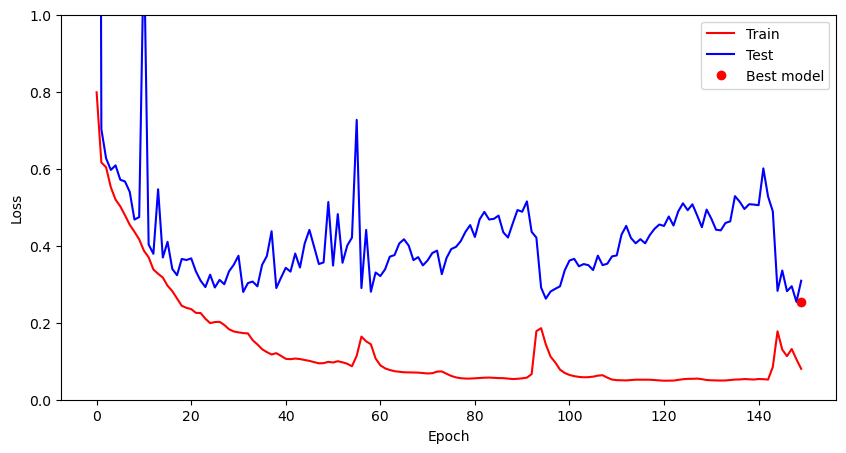

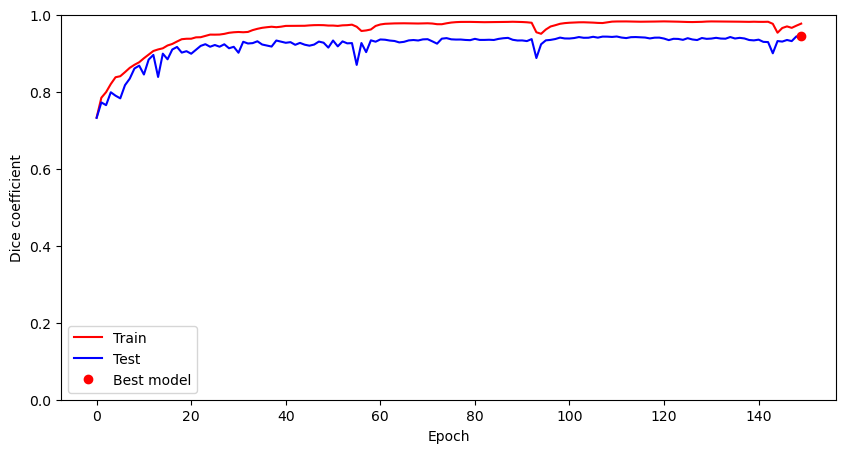

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(loss_train, label='Train', color='red')
plt.plot(loss_test, label='Test', color='blue')
plt.plot(bestEpoch, loss_test[bestEpoch-1], 'ro', label='Best model')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(dice_train, label='Train', color='red')
plt.plot(dice_test, label='Test', color='blue')
plt.plot(bestEpoch, dice_test[bestEpoch-1], 'ro', label='Best model')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.ylabel('Dice coefficient')
plt.legend()
plt.show()

In [21]:
model = bestModel # Setting the best model

In [22]:
# predict_image function to predict the mask of an image
def predict_image(model, image, mask):
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))['out']
        output = output.squeeze(0).squeeze(0)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()
    
    binary_output = (output > 0.5).astype(int)
    true_mask = mask.squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    # Plot the image, the predicted mask, and the true mask
    ax[0].imshow(image.cpu().permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[1].imshow(binary_output, cmap='gray')
    ax[1].set_title("Predicted Mask")
    ax[2].imshow(true_mask, alpha=0.5, cmap='gray')
    ax[2].set_title("True Mask")
    plt.show()

## Train images

The predicted mask identify the horse and separate it from the background, showing a high level of similarity.

The contours and edges of the horse in the predicted mask align well with those in the true mask, indicating the model's precision in segmentation.

The main differences are in the details, the horse's ears are almost never recognised, while the hooves are sometimes not defined as they should.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


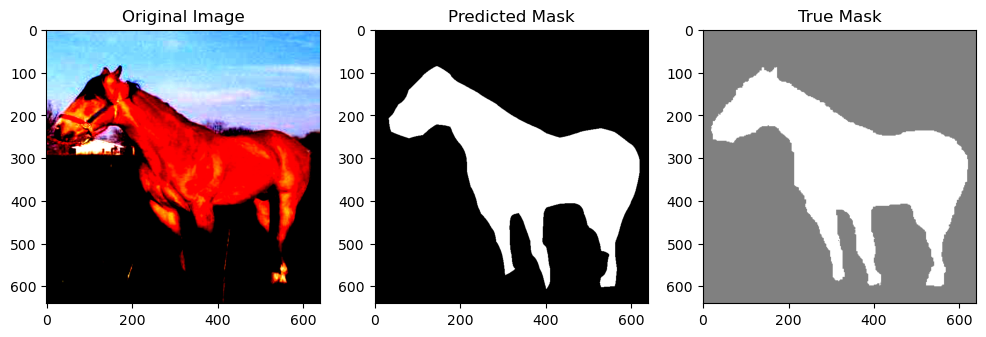

In [43]:
idx = 19
image = train_images[idx]
mask = train_masks[idx]
image = image.cuda()
predict_image(model, image, mask)

## Test images

The contours and edges of the horse in the predicted mask align fairly well with those in the true mask, but there are some discrepancies, particularly around the legs and finer features of the horse, indicating areas where the model could improve.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


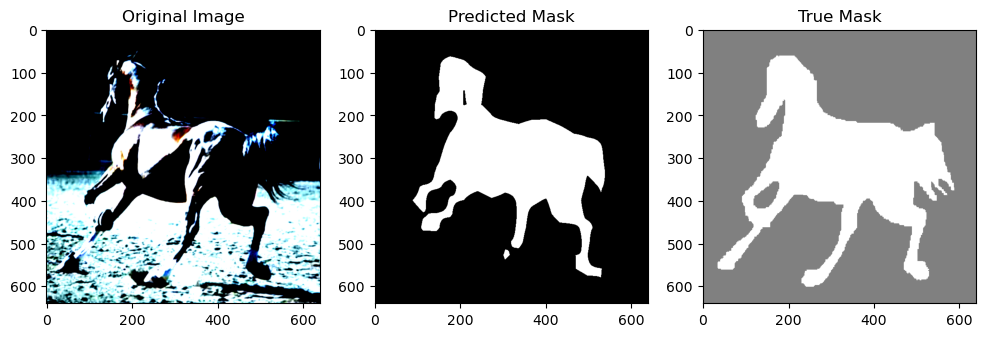

In [40]:
idx = 19
image = test_images[idx]
mask = test_masks[idx]
image = image.cuda()
predict_image(model, image, mask)

## Model Performance and Potential Improvements

Upon examining the performance of the segmentation model on test images, it becomes evident that there are both strengths and areas for potential enhancement. 

The model's predicted mask effectively captures the general shape of the horse, aligning well with the true mask provided as ground truth. 

However, finer details, particularly around the legs and more intricate features, show some discrepancies.



Possible improvments:

&emsp; - Currently, the model utilizes the outputs from the third and fourth levels of the network. Incorporating outputs from the first and second levels could provide additional spatial information and finer details, improving the segmentation quality, especially for smaller and more intricate features of the object.

&emsp; - Working with higher-resolution images can significantly enhance the model's ability to capture minute details. Higher resolution allows the model to discern finer edges and subtle variations in the object, leading to more precise segmentation.

&emsp; - Increasing the size of the training dataset can improve the model's robustness and generalization.
